<a href="https://colab.research.google.com/github/iams0rakim/projects/blob/main/DCGAN_with_Parasitized_Cell_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext tensorboard
import os
from glob import glob
import time
import random

import IPython.display as display
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import PIL
from PIL import Image
import imageio
import numpy as np 

import tensorflow as tf
from tensorflow.keras import layers
%matplotlib inline

In [ ]:
!unzip "/content/cell_images_32.zip" -d cell_images_32/

In [ ]:
EXPERIMENT_ID = "train_1"
MODEL_SAVE_PATH = os.path.join("cell_images_32/results/", EXPERIMENT_ID)
if not os.path.exists(MODEL_SAVE_PATH):
    os.makedirs(MODEL_SAVE_PATH)
CHECKPOINT_DIR = os.path.join(MODEL_SAVE_PATH, 'training_checkpoints')

DATA_PATH = "cell_images_32/"

BATCH_SIZE = 64
EPOCHS = 20000
LATENT_DEPTH = 100
IMAGE_SHAPE = [32,32]
n_ch = 3
LR = 1e-4

seed = random.seed(30)

In [ ]:
image_count = len(list(glob(str(DATA_PATH + '*.png'))))
image_count

6000

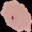

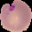

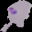

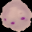

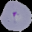

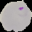

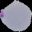

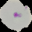

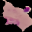

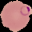

In [ ]:
cell_images_path = list(glob(str(DATA_PATH + '*.png')))
for image_path in cell_images_path[:10]:
    display.display(Image.open(str(image_path)))

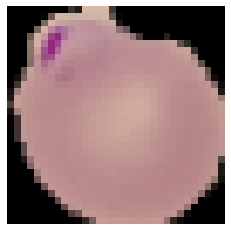

In [ ]:
image = mpimg.imread(cell_images_path[20])
plt.axis("off")
plt.imshow(image)

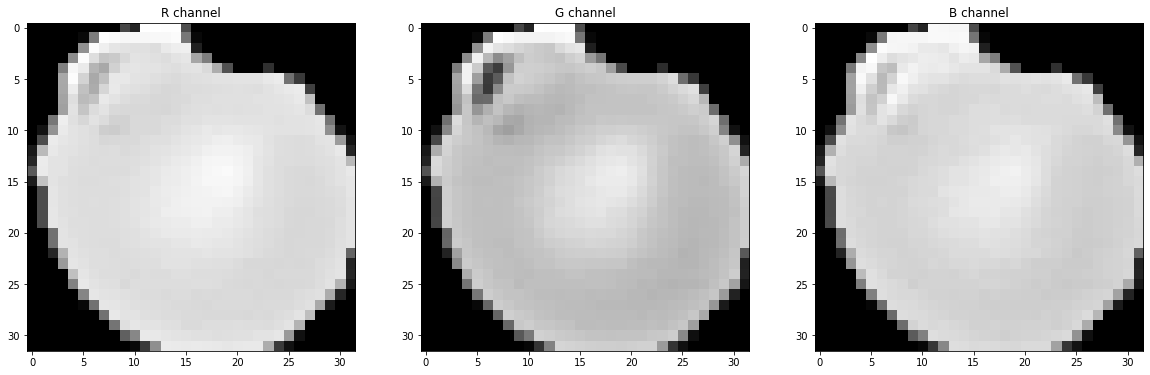

In [ ]:

r = image[:,:,0]
g = image[:,:,1]
b = image[:,:,2]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.set_title('R channel')
ax1.imshow(r, cmap='gray')
ax2.set_title('G channel')
ax2.imshow(g, cmap='gray')
ax3.set_title('B channel')
ax3.imshow(b, cmap='gray')

In [ ]:
@tf.function
def preprocessing_data(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SHAPE[0],IMAGE_SHAPE[1]])
    image = image / 255.0
    return image

In [ ]:
def dataloader(paths):
    dataset = tf.data.Dataset.from_tensor_slices(paths)
    dataset = dataset.shuffle(10* BATCH_SIZE)
    dataset = dataset.map(preprocessing_data)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(1)
    return dataset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


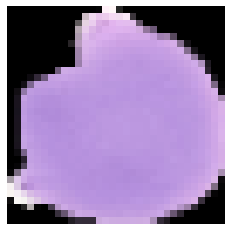

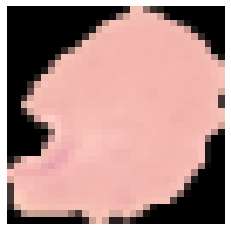

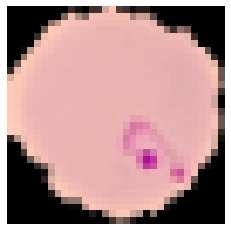

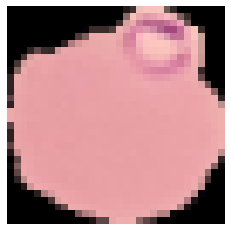

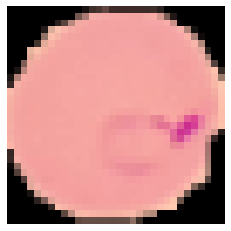

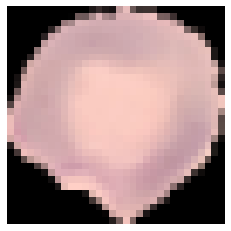

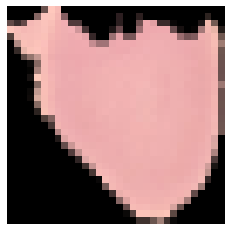

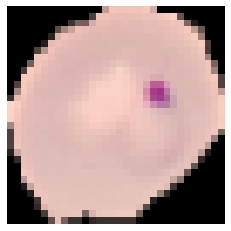

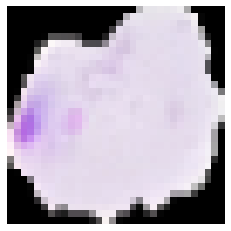

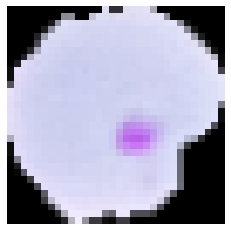

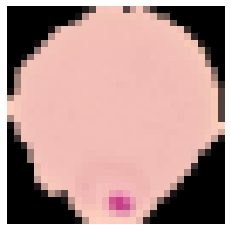

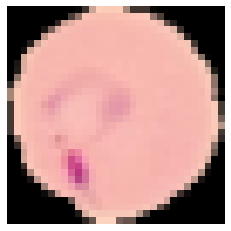

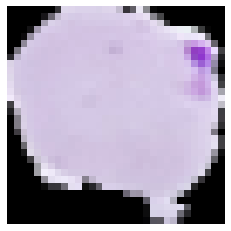

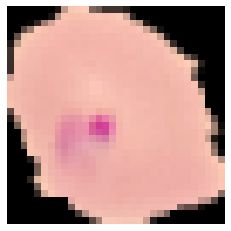

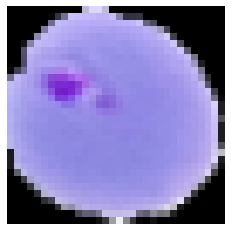

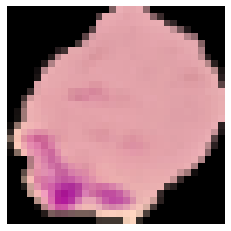

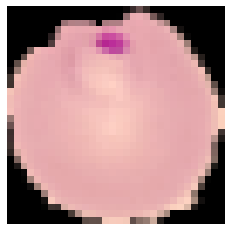

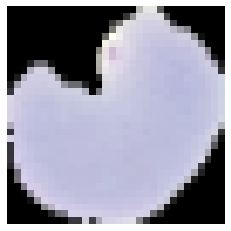

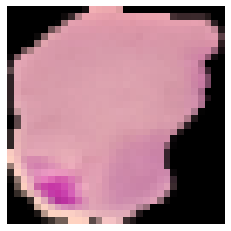

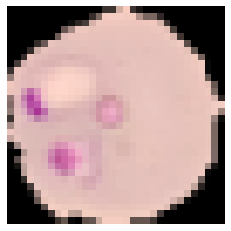

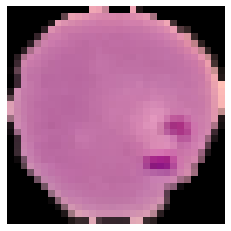

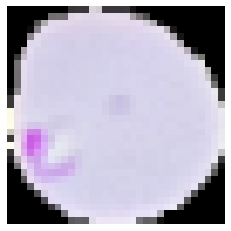

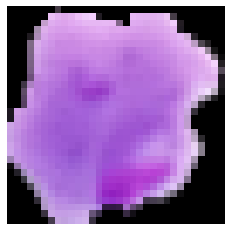

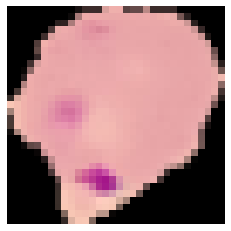

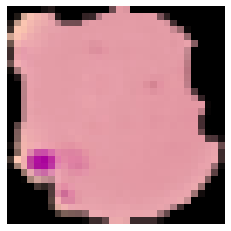

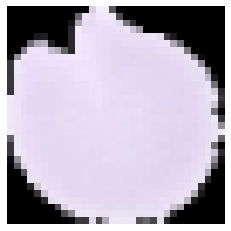

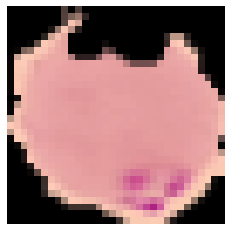

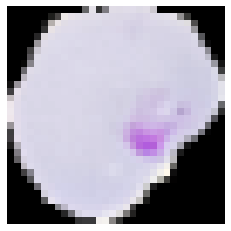

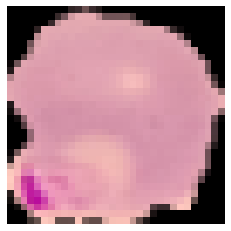

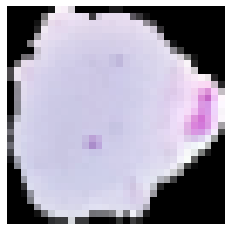

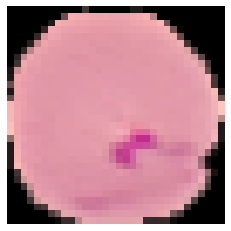

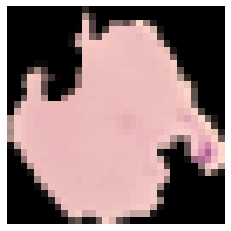

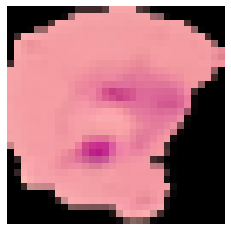

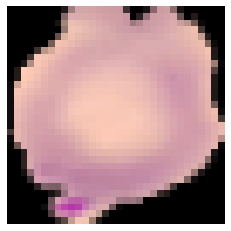

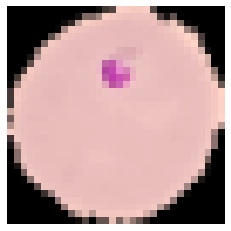

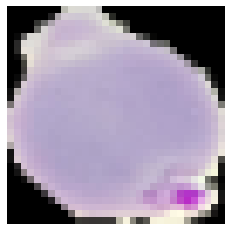

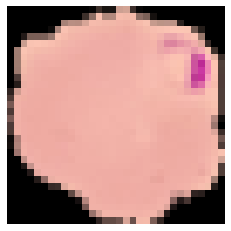

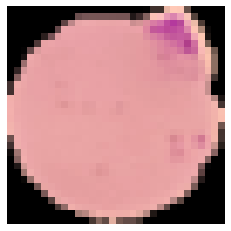

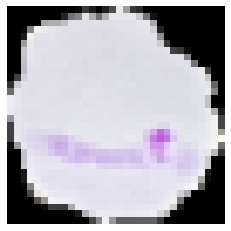

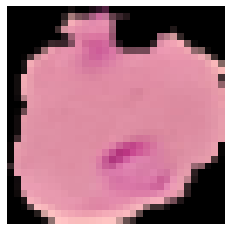

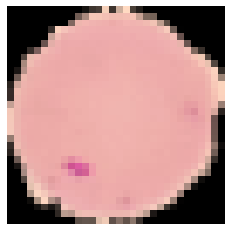

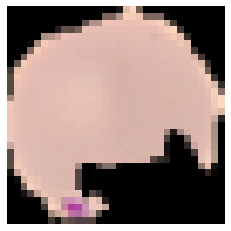

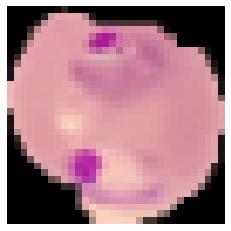

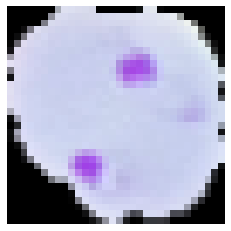

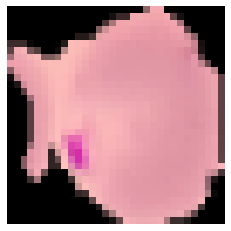

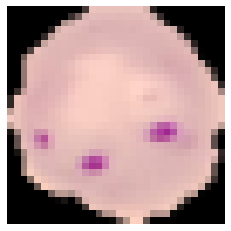

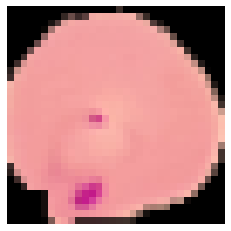

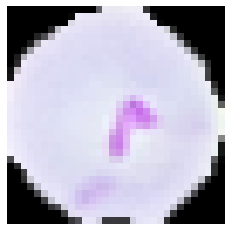

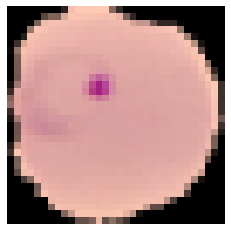

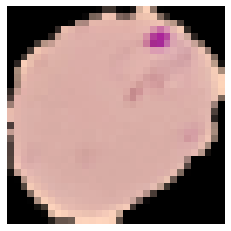

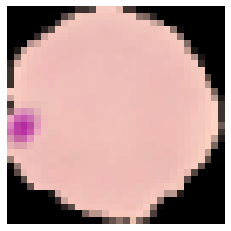

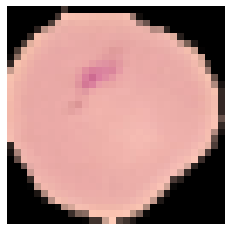

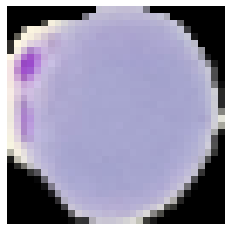

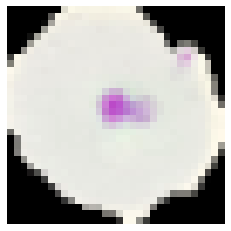

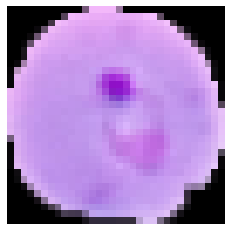

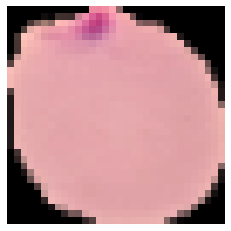

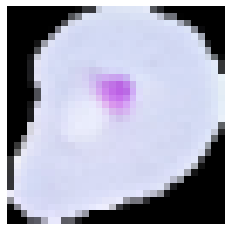

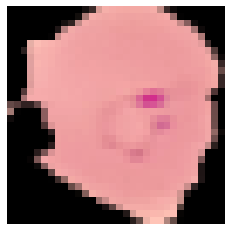

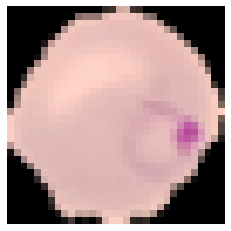

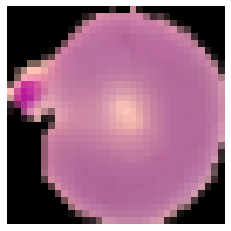

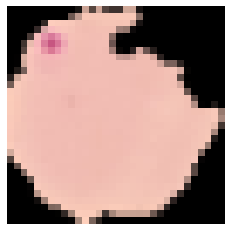

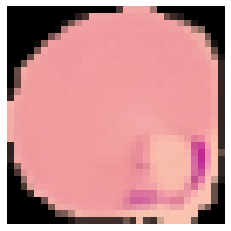

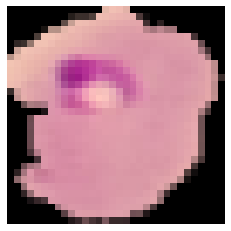

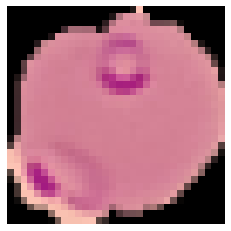

In [ ]:
dataset = dataloader(cell_images_path)
for batch in dataset.take(1):
    for img in batch:
        img_np = img.numpy()
        plt.figure()
        plt.axis('off')
        plt.imshow((img_np-img_np.min())/(img_np.max()-img_np.min()))

In [ ]:
image_list = []
for filename in cell_images_path:
    im=Image.open(filename)
    im =im.resize((IMAGE_SHAPE[0],IMAGE_SHAPE[1]))
    image_list.append(im)

In [ ]:
images_processed = []
for image in image_list:
    gan_train_images = np.asarray(image)
    gan_train_images = gan_train_images.astype('float32') /255.0
    images_processed.append(gan_train_images)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


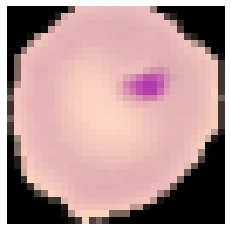

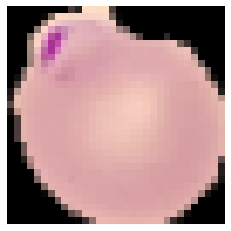

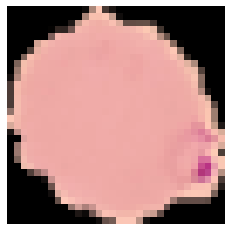

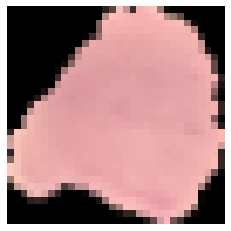

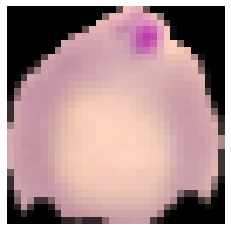

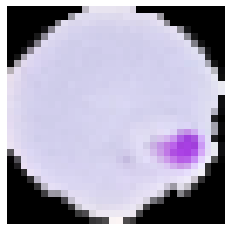

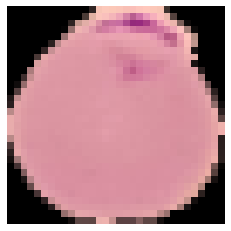

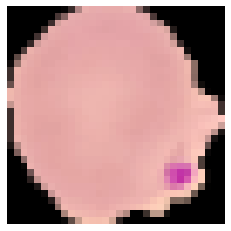

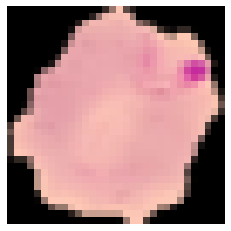

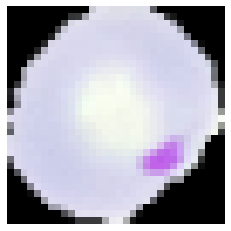

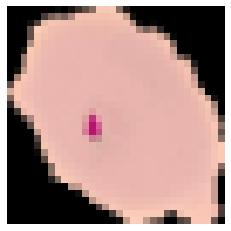

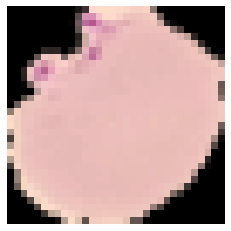

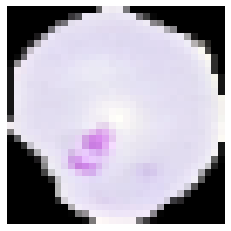

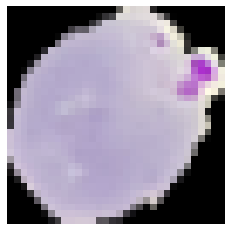

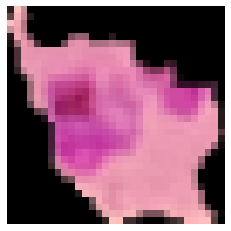

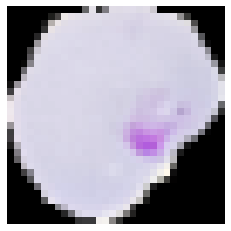

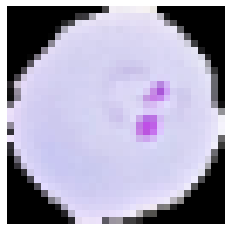

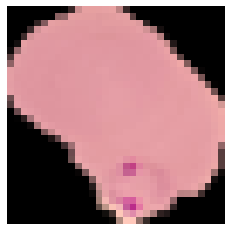

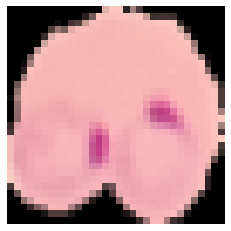

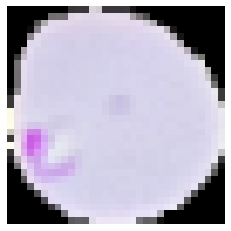

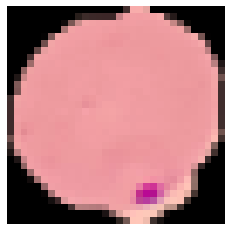

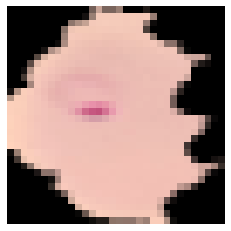

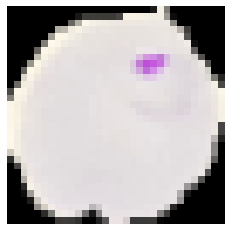

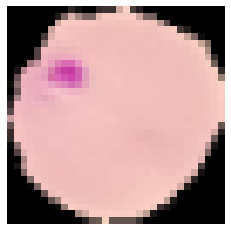

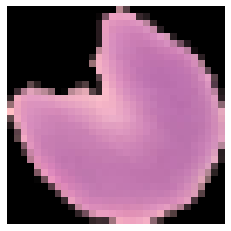

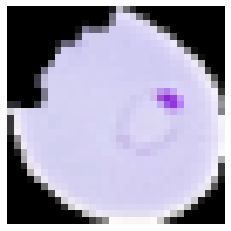

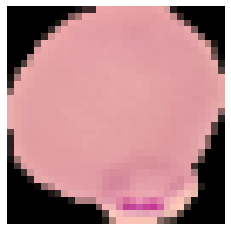

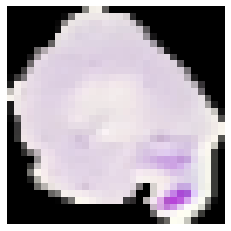

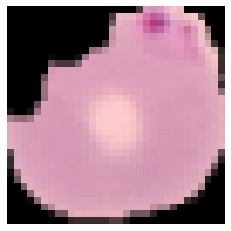

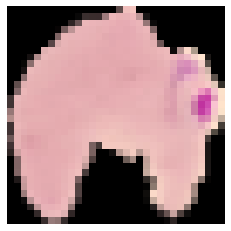

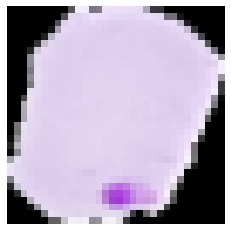

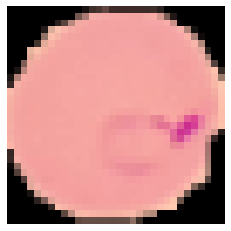

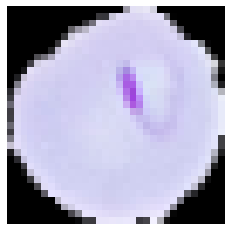

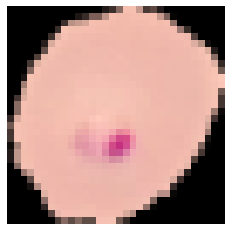

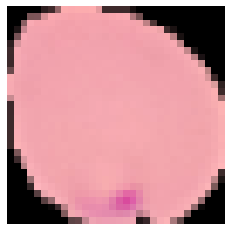

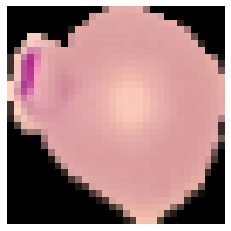

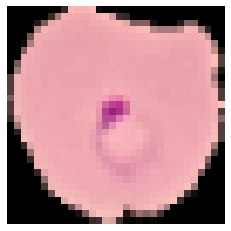

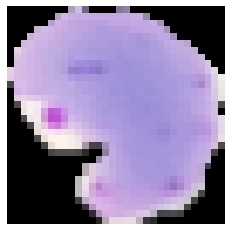

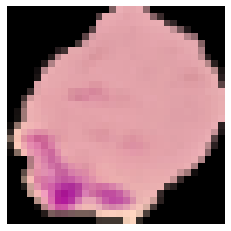

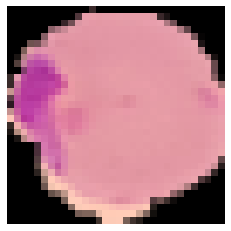

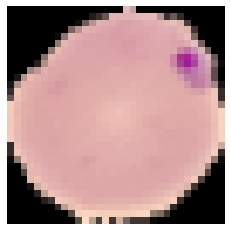

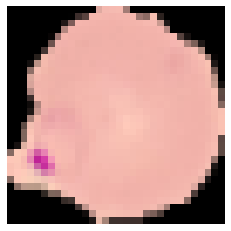

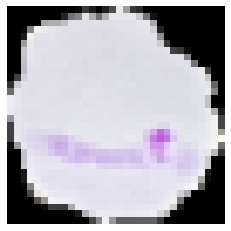

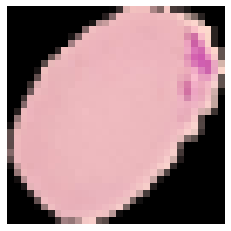

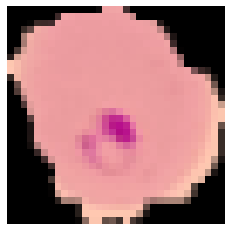

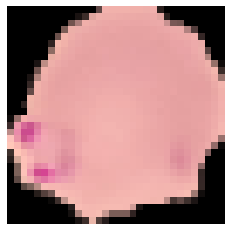

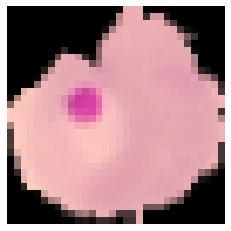

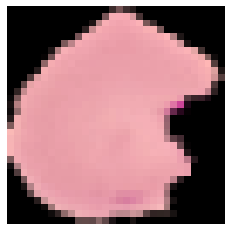

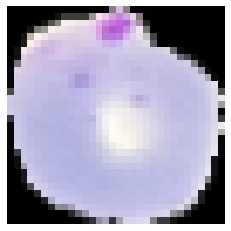

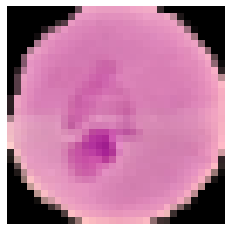

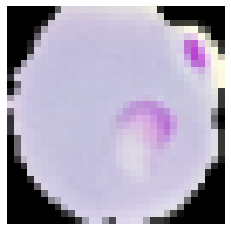

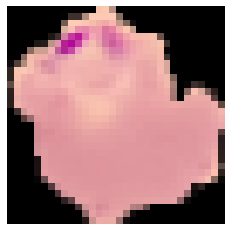

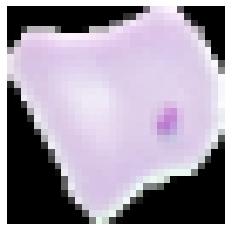

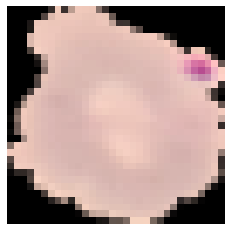

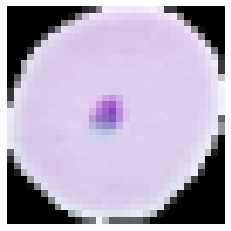

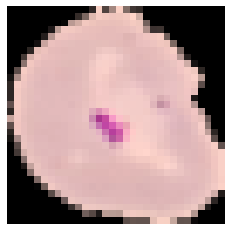

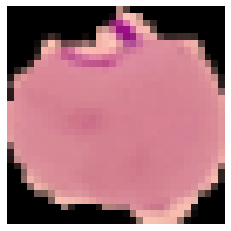

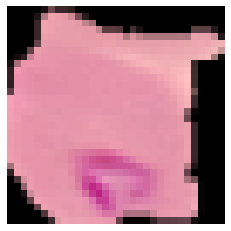

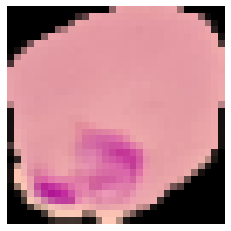

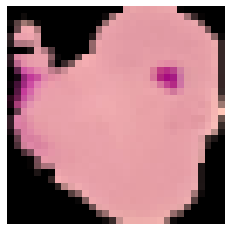

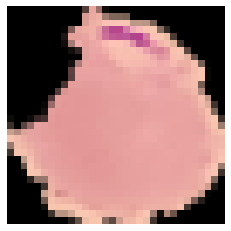

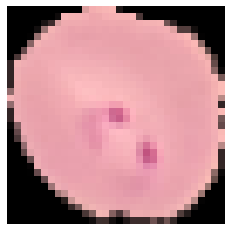

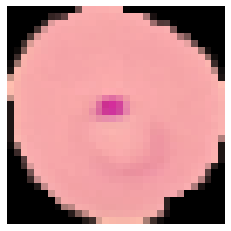

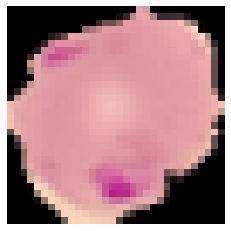

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(images_processed).shuffle(10* BATCH_SIZE).batch(BATCH_SIZE)
for batch in dataset.take(1):
    for img in batch:
        img_np = img.numpy()
        plt.figure()
        plt.axis('off')
        plt.imshow((img_np-img_np.min())/(img_np.max()-img_np.min()))

In [ ]:
def make_generator_model():

    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(100,)))
    model.add(layers.LeakyReLU())


    model.add(layers.Reshape((4, 4, 256)))
    assert model.output_shape == (None, 4, 4, 256) 


    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128) 
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64) 
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())


    model.add(layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())


    model.add(layers.Conv2DTranspose(3, (3, 3), strides=(1, 1), padding='same', 
                                     use_bias=False, activation='tanh')) 
    assert model.output_shape == (None, 32, 32, 3) 

    return model

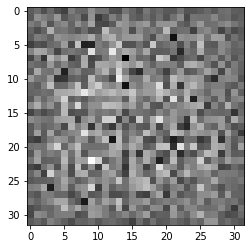

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same',
                                     input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
 
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
 
    model.add(layers.Flatten())
 
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00036671]], shape=(1, 1), dtype=float32)


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 10000
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)


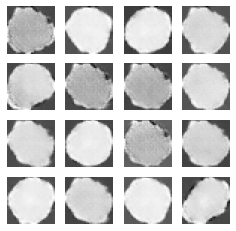

Time for epoch 243 is 68.49191331863403 sec


In [ ]:
# Model training
%%time
train(dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Create GIF
# Displays a single image using epoch numbers.

def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob(os.path.join(MODEL_SAVE_PATH, 'image*.png'))
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(anim_file)